# PCA + Neural Network Classifier with MNIST


## Libraries

In [1]:
# libraries
using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, f1score, coerce
using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

#using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
#using Distributions

using Plots; gr()
#using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [113]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

function batchImage2Matrix(imagesArray3D)
    vectorOfImageVectors = batchImage2Vector(imagesArray3D)
    M = reduce(hcat, vectorOfImageVectors)
    M'
end

function batchImage2DF(imagesArray3D)
    M = batchImage2Matrix(imagesArray3D)
    DataFrame(M, :auto)
end


batchImage2DF (generic function with 1 method)

In [3]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

## Loading the data

,,,,

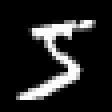
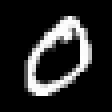
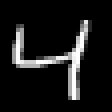
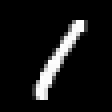
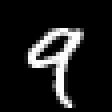

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [67]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Data preprocessing

Flux primarily works with matrices and vectors

In [106]:
function preprocessing(X, y)
    xs = batchImage2Vector(X)
    ys = [Flux.onehot(i, 0:9) for i in y]
    
    #PCA = @load PCA pkg=MultivariateStats verbosity=0
    #reducer = PCA(pratio = 0.95)
    #std = Standardizer()
    #reducerStdModel = @pipeline reducer std
    #mach = MLJ.machine(reducerStdModel, xs) |> fit!
    #xs2 = MLJ.transform(mach, xs)   # for UNsupervised models

    xs = Flux.batch(xs)
    ys = Flux.batch(ys)
    
    return (xs, ys)
end

X, y = preprocessing(trainX, trainY);

In [107]:
typeof(X), size(X)

(Matrix{Float64}, (784, 42001))

In [108]:
typeof(y), size(y)

(Flux.OneHotArray{UInt32, 10, 1, 2, Vector{UInt32}}, (10, 42001))

### Exemplo preliminar DNN

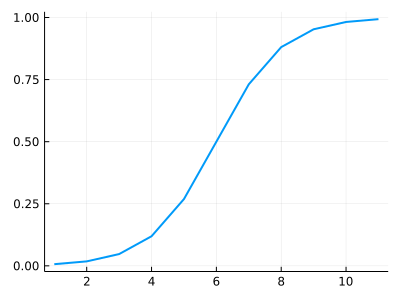

In [35]:
# built-in sigmoid function
plot(σ.(-5:5), size=(400,300), linewidth=2, legend=false)

In [109]:
d, N = size(X)
model = Dense(d, 9, σ)

Dense(784, 9, σ)    # 7_065 parameters

In [110]:
model.weight

9×784 Matrix{Float32}:
  0.00184503   0.00449559   0.039954    …  -0.0396278    0.0775316
 -0.0858011   -0.0839253    0.0498029      -0.0793852   -0.0147056
  0.0537988   -0.0658835    0.0783891       0.0459317    0.052662
 -0.00971536   0.0016528   -0.0582907       0.0158898   -0.0618605
  0.0464663   -0.0462108   -0.0833647      -0.0337974    0.0423917
  0.0209642   -0.0363835    0.0776987   …   0.00722275   0.0813175
  0.00871784   0.0747349   -0.0864302       0.00549751   0.0392234
  0.00657919  -0.0539198   -0.0852616       0.0608171    0.0850082
  0.0852403    0.00475274  -0.00776706     -0.0679439    0.0235639

In [111]:
model.bias

9-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [112]:
x1 = X[1,:] |> Array
model(x1)

LoadError: DimensionMismatch("matrix A has dimensions (9,784), vector B has length 42001")

In [41]:
N, d = size(X_til)
model = Dense(d, 9, σ)
losses(x, y) = Flux.mse(model(x), y)

Flux.train!(losses, Flux.params(model), zip(X_til |> Matrix, y), Descent)

LoadError: MethodError: no method matching (::Dense{typeof(σ), Matrix{Float32}, Vector{Float32}})(::Float64)
[0mClosest candidates are:
[0m  (::Dense)([91m::AbstractVecOrMat{T} where T[39m) at /home/ciro/.julia/packages/Flux/qAdFM/src/layers/basic.jl:156
[0m  (::Dense)([91m::AbstractArray[39m) at /home/ciro/.julia/packages/Flux/qAdFM/src/layers/basic.jl:161